# Credit Risk Classification
Classify whether someone is going to default or not in the future based on personal data and loan data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import log, ceil 
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

# Import data

In [2]:
data = pd.read_csv('credit_risk_dataset.csv')

In [3]:
data

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [63]:
data['loan_intent'].value_counts()

EDUCATION            6451
MEDICAL              6065
VENTURE              5716
PERSONAL             5517
DEBTCONSOLIDATION    5212
HOMEIMPROVEMENT      3605
Name: loan_intent, dtype: int64

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


# Metadata
To simplify data processing, below are defined column names grouped to their respective data types

In [5]:
target = 'loan_status'

In [6]:
drop_col = ['loan_percent_income']

Note: We don't use 'percent_income' as a feature as the column is derived from two other features and is more complicated to reason by the end users. We want to keep things simple.

In [7]:
num = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'cb_person_cred_hist_length']
cat_ord = ['loan_grade']
cat = ['person_home_ownership', 'loan_intent', 'cb_person_default_on_file']

# Drop unused column

In [8]:
data.drop(drop_col, axis=1, inplace=True)

# Handle outliers
See if there's any unreasonable number within the raw data and decide what to do with it

In [9]:
data.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
person_age,32581.0,27.734600,6.348078,20.00,23.0,26.00,30.00,144.00
person_income,32581.0,66074.848470,61983.119168,4000.00,38500.0,55000.00,79200.00,6000000.00
person_emp_length,31686.0,4.789686,4.142630,0.00,2.0,4.00,7.00,123.00
loan_amnt,32581.0,9589.371106,6322.086646,500.00,5000.0,8000.00,12200.00,35000.00
loan_int_rate,29465.0,11.011695,3.240459,5.42,7.9,10.99,13.47,23.22
loan_status,32581.0,0.218164,0.413006,0.00,0.0,0.00,0.00,1.00
cb_person_cred_hist_length,32581.0,5.804211,4.055001,2.00,3.0,4.00,8.00,30.00


From the table above, we found maximum number of "person_emp_length" and "person_age" is unreasonable. Up until 2021, there is no way human can live past 123 years old.

Text(0.5, 1.0, 'person_age histogram')

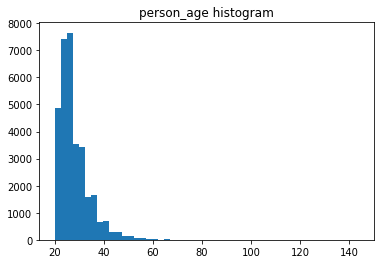

In [10]:
plt.hist(data['person_age'], bins=50)
plt.title("person_age histogram")

We filter "person_age" to only below 73 years, which is the average human life expectancy according to the United Nations, 2019

In [11]:
data = data[data['person_age'] < 73]

Text(0.5, 1.0, 'person_emp_length histogram')

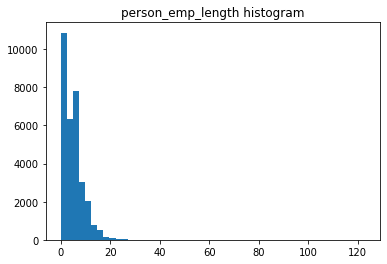

In [12]:
plt.hist(data['person_emp_length'], bins=50)
plt.title("person_emp_length histogram")

We filter "person_age" to only below 45 years

In [13]:
data = data[(pd.isnull(data[['person_emp_length']]).any(axis=1)) | (data['person_emp_length'] < 45)]

Describe the data again to see if the filters are working

In [14]:
data.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
person_age,32566.0,27.705859,6.152800,20.00,23.0,26.00,30.00,70.00
person_income,32566.0,65880.476386,52537.116859,4000.00,38500.0,55000.00,79200.00,2039784.00
person_emp_length,31671.0,4.780714,4.028718,0.00,2.0,4.00,7.00,38.00
loan_amnt,32566.0,9588.656881,6320.600578,500.00,5000.0,8000.00,12200.00,35000.00
loan_int_rate,29453.0,11.011881,3.240596,5.42,7.9,10.99,13.47,23.22
loan_status,32566.0,0.218234,0.413053,0.00,0.0,0.00,0.00,1.00
cb_person_cred_hist_length,32566.0,5.799423,4.043217,2.00,3.0,4.00,8.00,30.00


In [15]:
X = data.drop(columns=target).copy()
y = data[target].copy()

# Check for null values

In [16]:
data.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3113
loan_status                      0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

# Numerical correlation plot

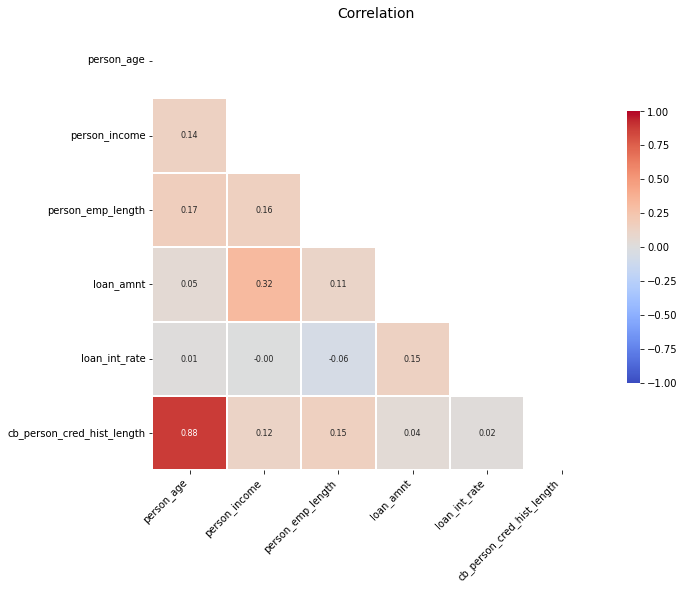

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_correlation(data):
    corr = data.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    fig = plt.figure(figsize=(10, 10))

    ax = sns.heatmap(
        corr, 
        mask=mask,
        vmin=-1, vmax=1, center=0,
        cmap='coolwarm',
        square=True,
        linewidths=0.3,
        annot=True,
        fmt=".2f",
        annot_kws={"size": 8},
        cbar_kws={"shrink": .5}
    )

    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )

    ax.set_title("Correlation", size=14)

    plt.show()
    
plot_correlation(X[num])

# Split data (stratified)

In [18]:
from sklearn.model_selection import train_test_split

SEED = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=SEED)

print("Number of Train :", len(y_train), f"{round(len(y_train) / len(y) * 100, 2)}%")
print("Number of Test :", len(y_test), f"{round(len(y_test) / len(y) * 100, 2)}%")

Number of Train : 22796 70.0%
Number of Test : 9770 30.0%


In [19]:
print("Percentage of target in Train :", np.mean(y_train))
print("Percentage of target in Test :", np.mean(y_test))

Percentage of target in Train : 0.21824004211265136
Percentage of target in Test : 0.21821903787103378


# Data preprocessing

The steps are:
1. Impute missing 'person_emp_length' feature with 0
2. Impute missing 'loan_int_rate' feature with median
3. Create dummy variables for categorical features using one hot encoder
4. Convert ordinal category into numbers using ordinal encoder
5. Scale the features

In [20]:
# get data by types
def get_data_by_types(X_train, X_test):
    X_train_num, X_train_cat, X_train_cat_ord = X_train[num], X_train[cat], X_train[cat_ord]
    X_test_num, X_test_cat, X_test_cat_ord = X_test[num], X_test[cat], X_test[cat_ord]
    return X_train_num, X_train_cat, X_train_cat_ord, X_test_num, X_test_cat, X_test_cat_ord

In [21]:
X_train_num, X_train_cat, X_train_cat_ord, X_test_num, X_test_cat, X_test_cat_ord = get_data_by_types(X_train, X_test)

In [22]:
list_column_nan_data = data[data.columns[data.isnull().any()]].isnull().sum() * 100 / data.shape[0]
list_column_nan_data
imputed_col = list_column_nan_data.index.tolist()
imputed_col

['person_emp_length', 'loan_int_rate']

# impute missing "person_emp_length" with 0
Assuming empty values correspond to people that haven't been employed before

In [23]:
from sklearn.impute import SimpleImputer
imp_zero = SimpleImputer(strategy='constant', fill_value = 0)
imp_zero.fit(X_train_num[[imputed_col[0]]])

SimpleImputer(fill_value=0, strategy='constant')

In [24]:
X_train_num[imputed_col[0]] = imp_zero.transform(X_train_num[[imputed_col[0]]])
X_test_num[imputed_col[0]] = imp_zero.transform(X_test_num[[imputed_col[0]]])

# impute missing "loan_int_rate" median

In [25]:
imp_median = SimpleImputer(strategy='median')
imp_median.fit(pd.DataFrame(X_train_num[imputed_col[1]]))

SimpleImputer(strategy='median')

In [26]:
X_train_num[imputed_col[1]] = imp_median.transform(X_train_num[[imputed_col[1]]])
X_test_num[imputed_col[1]] = imp_median.transform(X_test_num[[imputed_col[1]]])

# imputer - dummy variables

In [27]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(drop='first')
ohe.fit(X_train_cat)

X_train_cat = ohe.transform(X_train_cat).toarray()
X_test_cat = ohe.transform(X_test_cat).toarray()

In [28]:
X_train_cat = pd.DataFrame(X_train_cat, columns=ohe.get_feature_names(cat), index=X_train.index)
X_test_cat = pd.DataFrame(X_test_cat, columns=ohe.get_feature_names(cat), index=X_test.index)

# ordinal category conversion

In [29]:
from sklearn.preprocessing import OrdinalEncoder
ord_cnv = OrdinalEncoder(dtype=np.int64)
ord_cnv.fit(X_train_cat_ord)

X_train_cat_ord = ord_cnv.transform(X_train_cat_ord)
X_test_cat_ord = ord_cnv.transform(X_test_cat_ord)

In [30]:
X_train_cat_ord = pd.DataFrame(X_train_cat_ord, columns=cat_ord, index=X_train.index)
X_test_cat_ord = pd.DataFrame(X_test_cat_ord, columns=cat_ord, index=X_test.index)

# Standard Scaler

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_num)


StandardScaler()

In [32]:
scaler.transform(X_train_num)
scaler.transform(X_test_num)

array([[-0.59971913, -0.35144468, -0.16286184,  0.8843707 ,  0.14708894,
        -0.68991666],
       [-0.59971913, -0.21384916,  0.81937204,  1.64343273, -1.33157178,
        -0.93775133],
       [-0.4374478 ,  1.17783132, -1.14509573,  0.06205349,  0.9915757 ,
        -0.44208199],
       ...,
       [ 1.34753683,  1.5552362 , -0.16286184, -0.72863613, -0.45472921,
         2.53193402],
       [ 0.21163752,  0.43481547,  1.06493052,  2.43412235,  1.11129221,
         1.04492601],
       [-0.27517647,  0.27756344,  0.08269663,  2.43412235,  0.83626779,
        -0.44208199]])

# Join

In [33]:
X_train_trans = X_train_num.join(X_train_cat_ord).join(X_train_cat)
X_test_trans = X_test_num.join(X_test_cat_ord).join(X_test_cat)

In [34]:
X_train_trans

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,cb_person_cred_hist_length,loan_grade,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_Y
32115,39,48000,0.0,3000,5.42,16,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14821,26,115200,10.0,4500,11.97,2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
31721,44,58000,2.0,15000,13.48,15,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
27333,34,121000,8.0,12000,14.59,8,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
25587,29,87000,4.0,15000,10.99,5,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30131,41,47000,5.0,7500,11.12,13,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
18042,29,192000,6.0,15000,14.27,6,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4380,22,40000,1.0,8000,16.00,3,4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
30536,37,780000,9.0,7500,12.18,15,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


One last null values check

In [35]:
print(X_train_trans.isnull().sum())
print(X_test_trans.isnull().sum())

person_age                     0
person_income                  0
person_emp_length              0
loan_amnt                      0
loan_int_rate                  0
cb_person_cred_hist_length     0
loan_grade                     0
person_home_ownership_OTHER    0
person_home_ownership_OWN      0
person_home_ownership_RENT     0
loan_intent_EDUCATION          0
loan_intent_HOMEIMPROVEMENT    0
loan_intent_MEDICAL            0
loan_intent_PERSONAL           0
loan_intent_VENTURE            0
cb_person_default_on_file_Y    0
dtype: int64
person_age                     0
person_income                  0
person_emp_length              0
loan_amnt                      0
loan_int_rate                  0
cb_person_cred_hist_length     0
loan_grade                     0
person_home_ownership_OTHER    0
person_home_ownership_OWN      0
person_home_ownership_RENT     0
loan_intent_EDUCATION          0
loan_intent_HOMEIMPROVEMENT    0
loan_intent_MEDICAL            0
loan_intent_PERSONAL          

# Training using XGBoost

In [36]:
xgb_opt =  XGBClassifier(n_estimators = 1000, 
                         max_depth = 10, 
                         learning_rate = 0.01,
                         gamma = 5, 
                         min_child_weight = 3, 
                         subsample = 0.5, 
                         random_state = SEED)
xgb_opt.fit(X_train_trans, y_train)

[13:30:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [37]:
yhat_train_xgb = xgb_opt.predict_proba(X_train_trans)[:, 1]
yhat_test_xgb = xgb_opt.predict_proba(X_test_trans)[:, 1]

In [38]:
# https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
def get_optimal_cutoff(tpr, fpr, thresholds):
    i = np.arange(len(tpr)) # index for df
    roc = pd.DataFrame({
        'fpr' : pd.Series(fpr, index=i),
        'tpr' : pd.Series(tpr, index = i), 
        '1-fpr' : pd.Series(1-fpr, index = i), 
        'tf' : pd.Series(tpr - (1-fpr), index = i), 
        'thresholds' : pd.Series(thresholds, index = i)})
    
    print(roc.iloc[[(roc.tf-0).abs().argmin()]])

    # Plot tpr vs 1-fpr
    fig, ax = plt.subplots()
    _ = plt.plot(roc['tpr'])
    _ = plt.plot(roc['1-fpr'], color = 'red')
    _ = plt.xlabel('1-False Positive Rate')
    _ = plt.ylabel('True Positive Rate')
    _ = plt.title('Receiver operating characteristic')
    _ = ax.set_xticklabels([])
    

In [39]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report

fpr_train_xgb, tpr_train_xgb, thresholds_train_xgb =roc_curve(y_train, 
                                                  yhat_train_xgb)
fpr_test_xgb, tpr_test_xgb, thresholds_test_xgb =roc_curve(y_test, 
                                               yhat_test_xgb)

roc_auc_train_xgb = auc(fpr_train_xgb, tpr_train_xgb)
roc_auc_test_xgb = auc(fpr_test_xgb, tpr_test_xgb)

print("ROC-AUC TRAIN", roc_auc_train_xgb)
print("ROC-AUC TEST", roc_auc_test_xgb)

ROC-AUC TRAIN 0.9689386441776244
ROC-AUC TEST 0.9399468172124468


          fpr       tpr     1-fpr        tf  thresholds
609  0.139042  0.859287  0.860958 -0.001671    0.145564


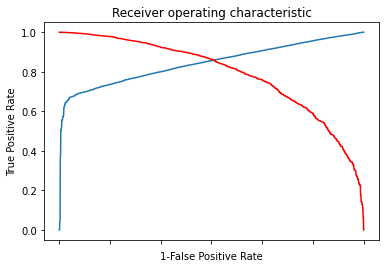

In [40]:
tpr = tpr_test_xgb
fpr = fpr_test_xgb

thresholds = thresholds_test_xgb
get_optimal_cutoff(tpr, fpr, thresholds)

In [41]:
threshold = 0.5

y_pred_train_xgb = np.where(yhat_train_xgb > threshold, 1, 0)
y_pred_test_xgb = np.where(yhat_test_xgb > threshold, 1, 0)

print(classification_report(y_test, 
                            y_pred_test_xgb))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      7638
           1       0.94      0.71      0.81      2132

    accuracy                           0.93      9770
   macro avg       0.93      0.85      0.88      9770
weighted avg       0.93      0.93      0.92      9770



# Training using Logistic Regression + Grid Search CV 

In [42]:
from sklearn.utils.fixes import loguniform
from sklearn.linear_model import LogisticRegression  
from sklearn.model_selection import GridSearchCV

lr =  LogisticRegression(random_state = SEED)

param_space = {
    "C": np.logspace(-4,4,20),
    "penalty" : ['l1', 'l2'],
    "max_iter": [100, 500, 1000],
    "random_state": [SEED]
}

clf = GridSearchCV(lr, 
                   param_space, 
                   scoring='roc_auc', 
                   cv=4, 
                   refit=True)

In [43]:
clf.fit(X_train_trans, y_train)

GridSearchCV(cv=4, estimator=LogisticRegression(random_state=42),
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'max_iter': [100, 500, 1000], 'penalty': ['l1', 'l2'],
                         'random_state': [42]},
             scoring='roc_auc')

In [44]:
clf.best_estimator_

LogisticRegression(C=0.0001, random_state=42)

In [45]:
yhat_train_lr = clf.predict_proba(X_train_trans)[:, 1]
yhat_test_lr = clf.predict_proba(X_test_trans)[:, 1]

In [46]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report

fpr_train_lr, tpr_train_lr, thresholds_train_lr =roc_curve(y_train, 
                                                  yhat_train_lr)
fpr_test_lr, tpr_test_lr, thresholds_test_lr =roc_curve(y_test, 
                                               yhat_test_lr)

roc_auc_train_lr = auc(fpr_train_lr, tpr_train_lr)
roc_auc_test_lr = auc(fpr_test_lr, tpr_test_lr)

print("ROC-AUC TRAIN", roc_auc_train_lr)
print("ROC-AUC TEST", roc_auc_test_lr)

ROC-AUC TRAIN 0.7615361584308953
ROC-AUC TEST 0.7608302419962988


           fpr       tpr     1-fpr        tf  thresholds
1206  0.316575  0.683396  0.683425 -0.000029    0.268806


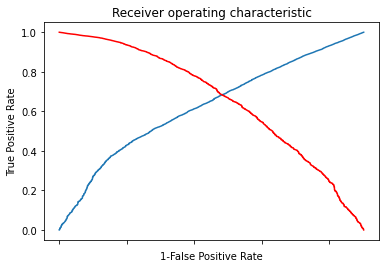

In [47]:
tpr = tpr_test_lr
fpr = fpr_test_lr

thresholds = thresholds_test_lr
get_optimal_cutoff(tpr, fpr, thresholds)

In [48]:
threshold = 0.5

y_pred_train_lr = np.where(yhat_train_lr > threshold, 1, 0)
y_pred_test_lr = np.where(yhat_test_lr > threshold, 1, 0)

print(classification_report(y_test, 
                            y_pred_test_lr))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      7638
           1       0.73      0.15      0.25      2132

    accuracy                           0.80      9770
   macro avg       0.77      0.57      0.57      9770
weighted avg       0.79      0.80      0.75      9770



# Decision
For this model, it is more acceptable to classify someone as default (1) where in fact it is not than classify someone as non-default (0) where in fact the person is default. This means false positive is more acceptable than false negative. It is also better to choose model with higher ROC-AUC as higher means the model can classify better.

From both classification report, we can see that **LR+Grid search is inferior in almost every levels to XGBoost**. LR+Grid search even only has 15% recall for 1 category. So, without much of a doubt, **XGBoost** is the best model candidate here.

# Full Pipeline with XGBoost

In [49]:
list_column_nan_data = data[data.columns[data.isnull().any()]].isnull().sum() * 100 / data.shape[0]
list_column_nan_data
imputed_col = list_column_nan_data.index.tolist()
imputed_col

['person_emp_length', 'loan_int_rate']

In [50]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

impute_zero_pipe = Pipeline(steps=[
    ('imputer_zero', SimpleImputer(strategy='constant', fill_value = 0)),
    ('scaler', StandardScaler()),
])

impute_median_pipe = Pipeline(steps=[
    ('imputer_median', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop="first"))
])

cat_ord_pipe = Pipeline(steps=[
    ('ordinal_encoder', OrdinalEncoder(dtype=np.int64))
])

num_pipe = Pipeline(steps=[
    ('scaler', StandardScaler())
])


In [51]:
X_train

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,cb_person_default_on_file,cb_person_cred_hist_length
32115,39,48000,MORTGAGE,NaN,MEDICAL,A,3000,5.42,N,16
14821,26,115200,MORTGAGE,10.0,DEBTCONSOLIDATION,C,4500,11.97,Y,2
31721,44,58000,RENT,2.0,HOMEIMPROVEMENT,C,15000,13.48,Y,15
27333,34,121000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,12000,14.59,Y,8
25587,29,87000,MORTGAGE,4.0,HOMEIMPROVEMENT,B,15000,10.99,N,5
...,...,...,...,...,...,...,...,...,...,...
30131,41,47000,MORTGAGE,5.0,EDUCATION,B,7500,11.12,N,13
18042,29,192000,MORTGAGE,6.0,VENTURE,C,15000,14.27,Y,6
4380,22,40000,MORTGAGE,1.0,PERSONAL,E,8000,16.00,Y,3
30536,37,780000,RENT,9.0,HOMEIMPROVEMENT,B,7500,12.18,N,15


In [52]:
num_no_impute = [x for x in num if x not in imputed_col]
num_no_impute

['person_age', 'person_income', 'loan_amnt', 'cb_person_cred_hist_length']

In [53]:
print(cat)
print(cat_ord)
print(imputed_col)
print(num)
print(num_no_impute)

['person_home_ownership', 'loan_intent', 'cb_person_default_on_file']
['loan_grade']
['person_emp_length', 'loan_int_rate']
['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'cb_person_cred_hist_length']
['person_age', 'person_income', 'loan_amnt', 'cb_person_cred_hist_length']


In [54]:
preprocess = ColumnTransformer(transformers=[
    ('cat', cat_pipe, cat),
    ('cat_ord', cat_ord_pipe, cat_ord),
    ('impute_zero', impute_zero_pipe, [imputed_col[0]]),
    ('impute_median', impute_median_pipe, [imputed_col[1]]),
    ('num', num_pipe, num_no_impute)
], remainder='passthrough')


In [55]:
xgb_opt =  XGBClassifier(n_estimators = 1000, 
                         max_depth = 10, 
                         learning_rate = 0.01,
                         gamma = 5, 
                         min_child_weight = 3, 
                         subsample = 0.5, 
                         random_state = SEED)

full_pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', xgb_opt)
])

In [56]:
full_pipe.fit(X_train, y_train)

[13:31:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['person_home_ownership',
                                                   'loan_intent',
                                                   'cb_person_default_on_file']),
                                                 ('cat_ord',
                                                  Pipeline(steps=[('ordinal_encoder',
                                                                   OrdinalEncoder(dtype=<class 'numpy.int64'>))]),
                                                  ['loan_grade']),
                                                 ('impute_zero',
                                                  Pipeline(st

In [57]:
yhat_train = full_pipe.predict_proba(X_train)[:, 1]
yhat_test = full_pipe.predict_proba(X_test)[:, 1]

In [58]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report

fpr_train, tpr_train, thresholds_train =roc_curve(y_train, 
                                                  yhat_train)
fpr_test, tpr_test, thresholds_test =roc_curve(y_test, 
                                               yhat_test)

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

print("ROC-AUC TRAIN", roc_auc_train)
print("ROC-AUC TEST", roc_auc_test)

ROC-AUC TRAIN 0.9688756334277865
ROC-AUC TEST 0.9400372114936328


          fpr       tpr     1-fpr        tf  thresholds
582  0.139827  0.860225  0.860173  0.000052    0.146146


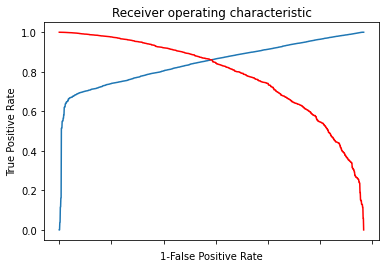

In [59]:
tpr = tpr_test
fpr = fpr_test

thresholds = thresholds_test
get_optimal_cutoff(tpr, fpr, thresholds)

In [60]:
thresholds_test

array([1.9983675e+00, 9.9836749e-01, 9.9099934e-01, ..., 6.2965187e-03,
       6.2939269e-03, 1.6429535e-03], dtype=float32)

In [61]:
threshold = 0.5

y_pred_train = np.where(yhat_train > threshold, 1, 0)
y_pred_test = np.where(yhat_test> threshold, 1, 0)

print(classification_report(y_test, 
                            y_pred_test))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      7638
           1       0.94      0.71      0.81      2132

    accuracy                           0.93      9770
   macro avg       0.93      0.85      0.88      9770
weighted avg       0.93      0.93      0.92      9770



# Save the model

In [62]:
import pickle

MODELNAME = 'MODEL-XGB-1.0.0.pkl'
PREPROCESSNAME = 'PREPROCESS-OHE-OE-IMP-SC-1.0.0.pkl'

final_model = full_pipe.named_steps['model']
final_pipe = full_pipe.named_steps['preprocess']

with open(MODELNAME, 'wb') as f: # save model
    pickle.dump(final_model, f)
    
with open(PREPROCESSNAME, 'wb') as f: # save pipeline
    pickle.dump(final_pipe, f)